In [1]:
# notebook last tested with abtem version 1.0.0beta8

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data
import matplotlib.pyplot as plt
from scipy import constants
from abtem import *
import numpy as np

/Users/schiotz/development/abTEM/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current version: 1.0.0beta32


# HRTEM simulation of nanoparticle

We build a nanoparticle with around 2000 atoms as a Wulff construction. We add vacuum to all sides of the model and the nanoparticle is rotated to align with the <110> zone axis.

Number of atoms: 16727


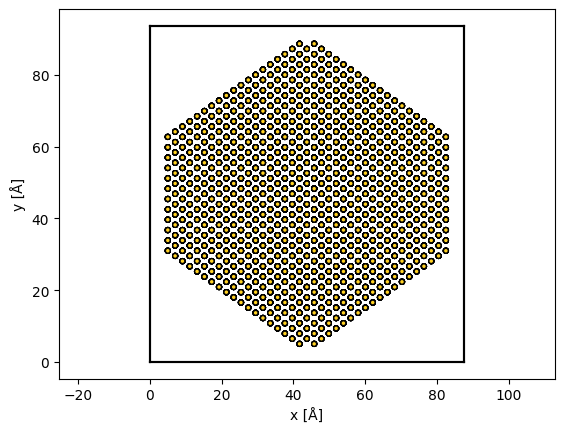

In [2]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets

esurf = [1.0, 1.1, 0.9] # Relative surface energies

size = 16000 # Target number of atoms

atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above'))

atoms.rotate(45, 'x', center='cop')

atoms.center(vacuum=5)

show_atoms(atoms)

print("Number of atoms:", len(atoms))

Get a reasonable sampling (0.05 Å)

In [3]:
gridpoints = int(max(atoms.cell[0,0], atoms.cell[1,1]) / 0.05)
print("Grid points:", gridpoints)
# Probably wise to round to a power of two
gridpoints = 2048

Grid points: 1873


We create the electrostatic potential. In this example, we use the infinite projection scheme to allow the notebook to run with low computational resources. The sampling used here is also a bit rough.

In [4]:
potential = Potential(atoms, 
                      gpts=gridpoints, 
                      slice_thickness=1, 
                      parametrization='kirkland', 
                      projection='infinite')

potential.sampling

(0.042734375000000005, 0.045734801928707186)

To simulate temperature effects set ``phonons`` to True below.  That enables *the frozen phonon method*, at a cost of a factor 30 in computer time.

The average square displacement of the atoms is calculated from the Debye temperature of the material (here gold) and the actual temperature, see: E. M. Mannebach, et al.  Nano Letters 15 (2015) 6889, suppl. online info.

$$
\left<u^2\right> = {3 \hbar^2 \over 2 m k_B \theta_D} \cdot \left(\frac14 + {T
      \over \theta_D}\right)
$$

In [5]:
phonons = False

if phonons:
    mass = ase.data.atomic_masses[ase.data.atomic_numbers['Au']]
    TD = 165  # Kittel
    T = 300
    U_squared = (3 * constants.hbar**2 / (2 *  mass * ase.units._amu * constants.k * TD)
                 * (1/4 + T / TD))
    sigmas = {'Au': np.sqrt(U_squared) * 1e10} # standard deviations of thermal vibrations
    print(sigmas)
    num_configs = 30 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
    potential = Potential(frozen_phonons, gpts=gridpoints, slice_thickness=1, parametrization='kirkland', projection='infinite')

We create the incoming plane wave and start the multislice simulation.

In [6]:
wave = PlaneWave(
    energy=300e3 # acceleration voltage in eV
)

exit_wave = wave.multislice(potential)

exit_wave.array.shape

Multislice: 100%|███████████████████████████████| 94/94 [00:19<00:00,  4.76it/s]


(2048, 2048)

We can get the complex exit wave function as an array. Note, when temperature effects are included, we get out a stack of exit waves by default, one for each frozen phonon configuration.

In [7]:
print(exit_wave.array.shape, exit_wave.array.dtype)

(2048, 2048) complex64


We show the intensity of the first exit wave and the intensity of the thermal ensemble. To get get the intensity of the thermal ensemble, we take the mean across the ensemble dimension after calculating the intensity.

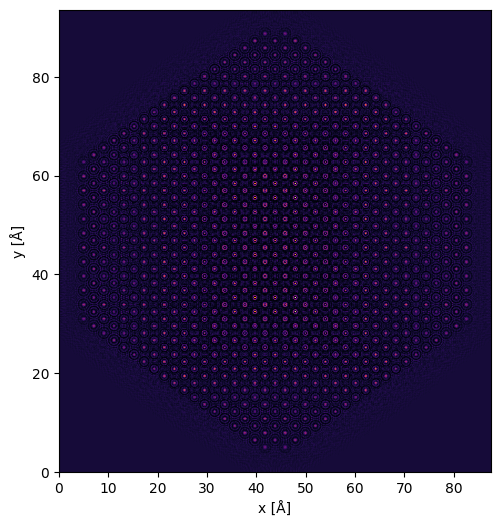

In [8]:
if phonons:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
    exit_wave.intensity().show(figsize=(6,6), ax=ax1, cmap='inferno')
    exit_wave.intensity().mean(0).show(figsize=(6,6), ax=ax2, cmap='inferno')
else:
    fig,ax1=plt.subplots(1,1,figsize=(6,6))
    exit_wave.intensity().show(ax=ax1, cmap='inferno')
# plt.savefig('test.png')

We create and show the contrast transfer function, see [docs](https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html) for a description of the parameters.

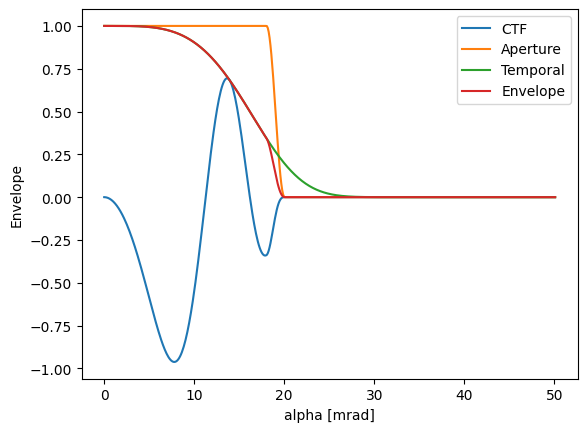

In [9]:
ctf = CTF(
    energy = wave.energy,
    semiangle_cutoff = 20, # mrad
    focal_spread = 40, # Å
    defocus = -160, # Å
    Cs = -7e-6 * 1e10, # Å
)

#ctf = CTF(energy=100e3, **{'defocus':10})

ctf.show(max_semiangle=50);

To simulate an image we apply the contrast transfer function of the objective lens. 

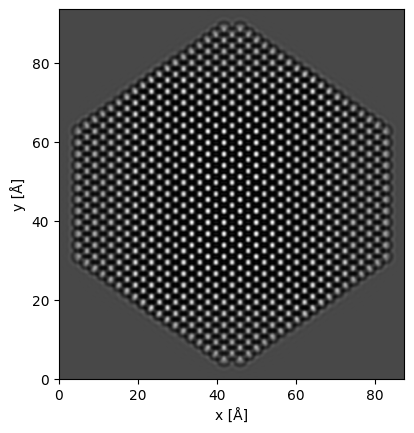

In [10]:
image_wave = exit_wave.apply_ctf(ctf)

if phonons:
    image_wave.intensity().mean(0).show()
else:
    image_wave.intensity().show()

We can get the diffraction pattern up to a chosen scattering angle, we can block the zero order spot and display it on a power scale.

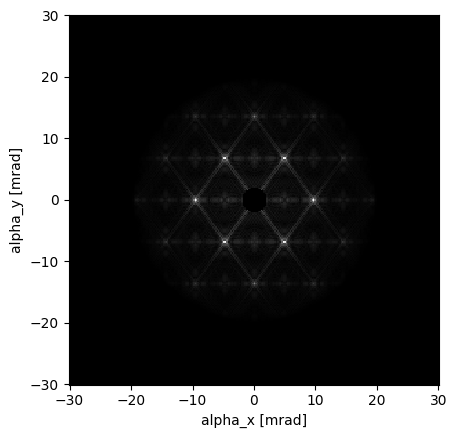

In [11]:
if phonons:
    image_wave.diffraction_pattern(max_angle=30, block_zeroth_order=2, ).mean(0).show(power=.25)
else:
    image_wave.diffraction_pattern(max_angle=30, block_zeroth_order=2, ).show(power=.25)


We can add noise to image, here using a basic Poisson model.

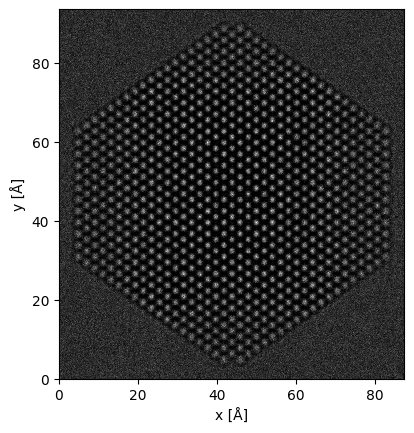

In [12]:
from abtem.noise import poisson_noise

measurement = image_wave.intensity()
noisy_measurement = poisson_noise(measurement, 5000)

noisy_measurement.show();